<a href="https://colab.research.google.com/github/cvt220106/google-colab/blob/main/tf6_cifar10_model_1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [2]:
!nvidia-smi

Wed Jul 27 03:02:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json
token = {"username":"jackyyoung","key":"8b0d8fc1f1c33da831ade74e571a01c7"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [5]:
!cat /content/kaggle.json

{"username": "jackyyoung", "key": "8b0d8fc1f1c33da831ade74e571a01c7"}

In [6]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [7]:
!pwd

/content


In [8]:
# !kaggle datasets download -d slothkong/10-monkey-species

In [9]:
!kaggle competitions download -c cifar-10

100% 713M/715M [00:19<00:00, 47.9MB/s]
100% 715M/715M [00:19<00:00, 37.6MB/s]


# 新段落

In [10]:
!ls /content/competitions/cifar-10

cifar-10.zip


In [11]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [12]:
!ls /content/

competitions  sample_data	    test.7z   trainLabels.csv
kaggle.json   sampleSubmission.csv  train.7z


In [13]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 357 kB 70.0 MB/s 
     |████████████████████████████████| 138 kB 71.4 MB/s 
     |████████████████████████████████| 2.4 MB 59.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 2.3 MB 53.0 MB/s 


In [14]:
!ls /content/competitions/cifar-10/train|wc -l

50000


In [15]:
#测试集
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [16]:
!ls /content/competitions/cifar-10/test|wc -l

300000


In [17]:
!unzip -o -d /content/competitions/cifar-10 ./sampleSubmission.csv.zip

unzip:  cannot find or open ./competitions/cifar-10/sampleSubmission.csv.zip, ./competitions/cifar-10/sampleSubmission.csv.zip.zip or ./competitions/cifar-10/sampleSubmission.csv.zip.ZIP.


In [19]:
#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './trainLabels.csv'
test_csv_file = './sampleSubmission.csv'
train_folder = 'competitions/cifar-10/train/'
test_folder = 'competitions/cifar-10/test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]，可以试这个
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('competitions/cifar-10/train/1.png', 'frog'),
 ('competitions/cifar-10/train/2.png', 'truck'),
 ('competitions/cifar-10/train/3.png', 'truck'),
 ('competitions/cifar-10/train/4.png', 'deer'),
 ('competitions/cifar-10/train/5.png', 'automobile')]
[('competitions/cifar-10/test/1.png', 'cat'),
 ('competitions/cifar-10/test/2.png', 'cat'),
 ('competitions/cifar-10/test/3.png', 'cat'),
 ('competitions/cifar-10/test/4.png', 'cat'),
 ('competitions/cifar-10/test/5.png', 'cat')]
50000 300000


In [20]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                            filepath       class
0  competitions/cifar-10/train/1.png        frog
1  competitions/cifar-10/train/2.png       truck
2  competitions/cifar-10/train/3.png       truck
3  competitions/cifar-10/train/4.png        deer
4  competitions/cifar-10/train/5.png  automobile
                                filepath       class
0  competitions/cifar-10/train/45001.png       horse
1  competitions/cifar-10/train/45002.png  automobile
2  competitions/cifar-10/train/45003.png        deer
3  competitions/cifar-10/train/45004.png  automobile
4  competitions/cifar-10/train/45005.png    airplane
                           filepath class
0  competitions/cifar-10/test/1.png   cat
1  competitions/cifar-10/test/2.png   cat
2  competitions/cifar-10/test/3.png   cat
3  competitions/cifar-10/test/4.png   cat
4  competitions/cifar-10/test/5.png   cat


In [21]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    #讲labels转换为id
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

#和上面一致
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [22]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),#为了是模型训练的更快
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                        

In [29]:
epochs = 100
callbacks= [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]
history = model.fit(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size,
                              callbacks=callbacks)                        

Epoch 1/100
1406/1406 [==============================] - 50s 36ms/step - loss: 0.4214 - accuracy: 0.8566 - val_loss: 0.7232 - val_accuracy: 0.8009
Epoch 2/100
1406/1406 [==============================] - 50s 36ms/step - loss: 0.4121 - accuracy: 0.8605 - val_loss: 0.4550 - val_accuracy: 0.8650
Epoch 3/100
1406/1406 [==============================] - 49s 35ms/step - loss: 0.3956 - accuracy: 0.8637 - val_loss: 0.4312 - val_accuracy: 0.8656
Epoch 4/100
1406/1406 [==============================] - 50s 35ms/step - loss: 0.3873 - accuracy: 0.8681 - val_loss: 0.4619 - val_accuracy: 0.8620
Epoch 5/100
1406/1406 [==============================] - 50s 36ms/step - loss: 0.3797 - accuracy: 0.8697 - val_loss: 0.5105 - val_accuracy: 0.8518
Epoch 6/100
1406/1406 [==============================] - 50s 35ms/step - loss: 0.3748 - accuracy: 0.8732 - val_loss: 0.4965 - val_accuracy: 0.8562
Epoch 7/100
1406/1406 [==============================] - 50s 35ms/step - loss: 0.3585 - accuracy: 0.8781 - val_loss: 0

{'loss': [0.421381413936615, 0.41205742955207825, 0.3955569863319397, 0.3872503340244293, 0.3797359764575958, 0.3747933506965637, 0.35850849747657776, 0.3531101644039154, 0.34636539220809937, 0.3397543132305145, 0.33185774087905884, 0.32674723863601685, 0.32155781984329224, 0.30572614073753357, 0.3071771264076233, 0.2979791760444641, 0.2885422706604004, 0.2942703366279602, 0.2840549051761627, 0.2765261232852936, 0.26813557744026184, 0.2716251313686371], 'accuracy': [0.8565869331359863, 0.8604785799980164, 0.863658607006073, 0.8681061863899231, 0.8696851134300232, 0.8731764554977417, 0.8780910968780518, 0.8782690167427063, 0.8822718262672424, 0.8847847580909729, 0.8860300779342651, 0.8883873224258423, 0.8906111121177673, 0.8940579891204834, 0.895014226436615, 0.8988169431686401, 0.9009295701980591, 0.90057373046875, 0.9023972749710083, 0.9033979773521423, 0.9085571765899658, 0.9070894718170166], 'val_loss': [0.7231941819190979, 0.45496734976768494, 0.43124717473983765, 0.461883217096328

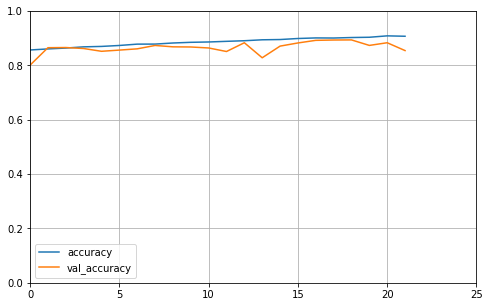

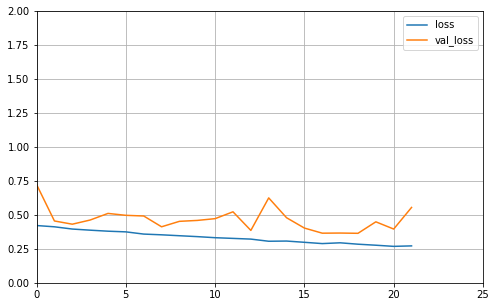

In [32]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, 25, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

# 对测试样本集进行预测


In [33]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [34]:
#这里运行时间太久，等上了GPU再说
test_predict = model.predict(test_generator,
                                       workers = 2,
                                       use_multiprocessing = True)

In [35]:
print(test_predict.shape)

(300000, 10)


In [36]:
#每一个样本预测输出的是10个概率值
print(test_predict[0:5])

[[8.53697397e-03 5.11474349e-03 1.66420080e-03 9.45749460e-04
  2.27529160e-03 6.08863833e-04 4.72291780e-04 5.09067439e-04
  4.20197612e-03 9.75670815e-01]
 [9.18870032e-01 1.15512509e-03 2.84573500e-04 1.02851634e-04
  3.13611294e-04 2.48115575e-05 9.10802410e-05 1.35064292e-05
  7.56566599e-02 3.48784635e-03]
 [9.56420987e-09 9.99968290e-01 4.39431748e-13 4.50429104e-11
  7.98033514e-13 7.06879650e-13 3.91738942e-12 1.46227269e-12
  3.78670117e-09 3.17118174e-05]
 [1.61913014e-03 9.81015774e-07 1.57221780e-06 2.60711431e-07
  3.19550367e-07 1.61230773e-07 1.14564023e-06 4.93545222e-08
  9.98373747e-01 2.59995500e-06]
 [8.90208781e-01 1.65480364e-04 9.89145339e-02 9.99790500e-04
  6.80044526e-03 2.58084416e-04 5.69263706e-04 2.33243700e-04
  1.63853704e-03 2.11935578e-04]]


In [37]:
#一个向量中谁的值最大，返回其下标
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [38]:
print(test_predict_class_indices[0:5])

[9 0 1 8 0]


In [39]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [40]:
print(test_predict_class[0:5])

['truck', 'airplane', 'automobile', 'ship', 'airplane']


In [41]:
#产生最终的报告
def generate_submissions(filename, predict_class):
  with open(filename, 'w') as f:
    f.write('id,label\n')
    for i in range(len(predict_class)):
      f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./submission.csv"
generate_submissions(output_file, test_predict_class)

In [42]:
!ls

competitions  sample_data	    submission.csv  train.7z
kaggle.json   sampleSubmission.csv  test.7z	    trainLabels.csv


In [43]:
!kaggle competitions submit -c cifar-10 -f submission.csv -m "Message"

100% 3.62M/3.62M [00:04<00:00, 941kB/s] 
Successfully submitted to CIFAR-10 - Object Recognition in Images